# Deploy machine learned models with ONNX

**Xavier Dupré** - Senior Data Scientist at Microsoft - Computer Science Teacher at [ENSAE](http://www.ensae.fr/)

Most of machine learning libraries are optimized to train models and not necessarily to use them for fast predictions in online web services. [ONNX](https://onnx.ai/) is one solution started last year by Microsoft and Facebook. This presentation describes the concept and shows some examples with [scikit-learn](http://scikit-learn.org/stable/) and [ML.net](https://github.com/dotnet/machinelearning).

**GitHub repos**

* [github/xadupre](https://github.com/xadupre)
* [github/sdpython](https://github.com/sdpython)

**Contributing to**

* [nimbusml](https://docs.microsoft.com/en-us/nimbusml/overview)
* [ml.net](https://github.com/dotnet/machinelearning)
* [onnxmltools](https://github.com/onnx/onnxmltools)
* [onnxruntime](https://docs.microsoft.com/en-us/python/api/overview/azure/onnx/intro?view=azure-onnx-py)
* [sklearn-onnx](https://github.com/onnx/sklearn-onnx)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=2)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyquickhelper.helpgen import NbImage

### Open source tools in this talk

In [3]:
import keras, lightgbm, onnx, skl2onnx, onnxruntime, sklearn, torch, xgboost
mods = [keras, lightgbm, onnx, skl2onnx, onnxruntime, sklearn, torch, xgboost]
for m in mods:
    print(m.__name__, m.__version__)

Using TensorFlow backend.


keras 2.3.1
lightgbm 2.3.1
onnx 1.7.105
skl2onnx 1.7.0
onnxruntime 1.3.993
sklearn 0.24.dev0
torch 1.5.0+cpu
xgboost 1.1.0


## The problem about deployment

### Learn and predict

* Two different purposes not necessarily aligned for optimization
* **Learn** : computation optimized for large number of observations (*batch prediction*)
* **Predict** : computation optimized for one observation (*one-off prediction*)
* Machine learning libraries optimize the **learn** scenario.

### One-off prediction with random forests

Benchmark of libraries for a regression problem.

In [4]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]
diabetes_X_train[:1]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613]])

In [5]:
from jupytalk.benchmark import make_dataframe
df = make_dataframe(diabetes_y_train, diabetes_X_train)
df.to_csv("diabetes.csv", index=False)
df.head(n=2)

,Label,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204


In [6]:
from jupytalk.benchmark import timeexec
measures_rf = []

#### scikit-learn

In [7]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
rf.fit(diabetes_X_train, diabetes_y_train)

RandomForestRegressor(n_estimators=10)

In [8]:
measures_rf += [timeexec("sklearn", "rf.predict(diabetes_X_test[:1])", 
                         context=globals())]

Average: 1.11 ms deviation 369.54 µs (with 50 runs) in [846.82 µs, 1.98 ms]


#### XGBoost

In [9]:
from xgboost import XGBRegressor
xg = XGBRegressor(n_estimators=10)
xg.fit(diabetes_X_train, diabetes_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
measures_rf += [timeexec("xgboost", "xg.predict(diabetes_X_test[:1])",
                         context=globals())]

Average: 1.38 ms deviation 251.41 µs (with 50 runs) in [1.18 ms, 1.98 ms]


#### LightGBM

In [11]:
from lightgbm import LGBMRegressor
lg = LGBMRegressor(n_estimators=10)
lg.fit(diabetes_X_train, diabetes_y_train)

LGBMRegressor(n_estimators=10)

In [12]:
measures_rf += [timeexec("lightgbm", "lg.predict(diabetes_X_test[:1])", 
                         context=globals())]

Average: 234.68 µs deviation 45.85 µs (with 50 runs) in [193.29 µs, 313.33 µs]


#### pure python

This would require to reimplement the prediction function.

#### Summary

In [13]:
import pandas
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df

,average,deviation,first,first3,last3,repeat,min5,max5,code,run
legend,,,,,,,,,,
lightgbm,0.000235,0.000046,0.000499,0.000348,0.000257,200,0.000193,0.000313,lg.predict(diabetes_X_test[:1]),50
sklearn,0.001113,0.000370,0.001451,0.001219,0.000916,200,0.000847,0.001982,rf.predict(diabetes_X_test[:1]),50
xgboost,0.001377,0.000251,0.002161,0.001656,0.001348,200,0.001183,0.001982,xg.predict(diabetes_X_test[:1]),50


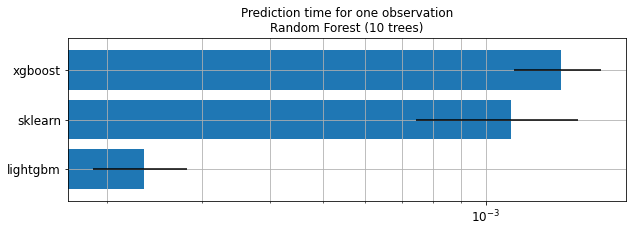

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

**Keep in mind**

* Trained trees are not necessarily the same.
* Performance is not compared.
* Order of magnitude is important here.

### What is batch prediction?

* Instead of running $N$ times 1 prediction
* We run 1 time $N$ predictions

The code can be found at [MS Experience 2018](http://www.xavierdupre.fr/app/jupytalk/helpsphinx/notebooks/onnx_deploy.html#what-is-batch-prediction).

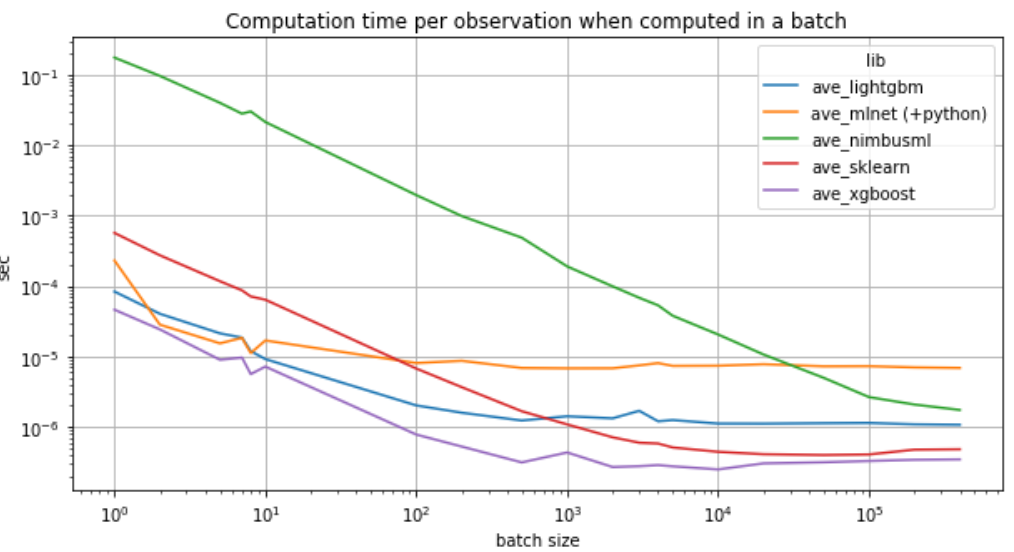

In [15]:
NbImage('batch.png', width=600)

## ONNX

ONNX can represent any pipeline of data.

Let's visualize a [machine learning pipeline](https://docs.microsoft.com/en-us/nimbusml/tutorials/c_a-visualize-a-pipeline) (see the code at [MS Experience](http://www.xavierdupre.fr/app/jupytalk/helpsphinx/notebooks/onnx_deploy.html#onnx-visually)).

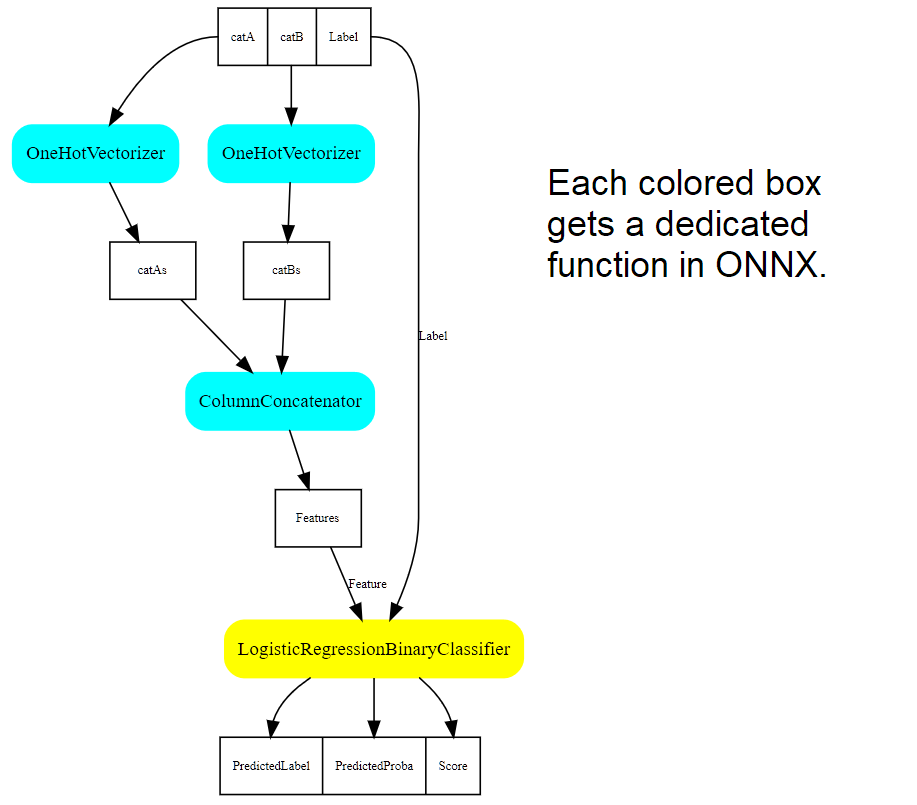

In [16]:
NbImage("pipeviz.png", width=500)

### ONNX = language to describe models

* Standard format to describe machine learning
* Easier to exchange, export

### ONNX = machine learning oriented

* [operators ML](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md)
* [operators](https://github.com/onnx/onnx/blob/master/docs/Operators.md)

Can represent any mathematical function handling numerical and text features.

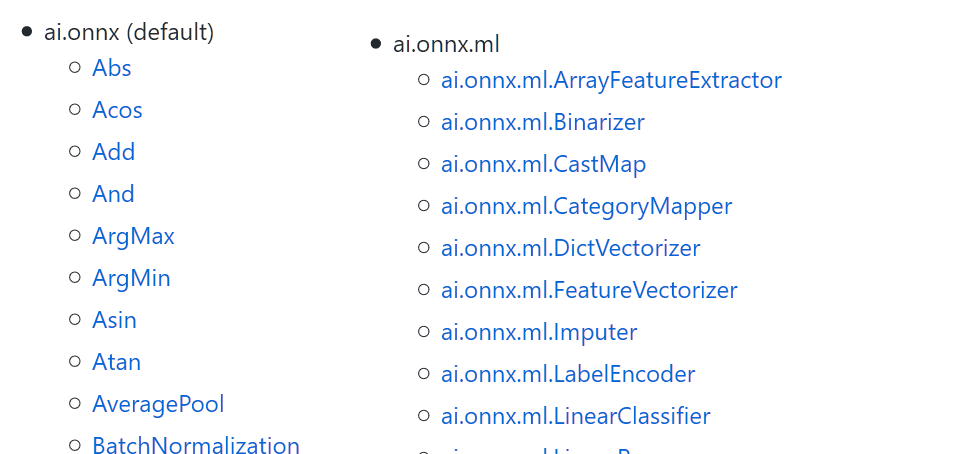

In [17]:
NbImage("onnxop.png", width=600)

### ONNX = efficient serialization

* Based on [google.protobuf](https://developers.google.com/protocol-buffers/)


### actively supported

* Microsoft
* Facebook
* first created to deploy deep learning models
* extended to other models

### Train somewhere, predict somewhere else

**Cannot optimize the code for both training and predicting.**

| Training         | Predicting         |
|------------------|--------------------|
| Batch prediction | One-off prediction |
| Huge memory      | Small memory       |
| Huge data        | Small data         |
| .                | High latency       |

### Libraries for predictions

* Optimized for predictions
* Optimized for a device

### ONNX Runtime

[ONNX Runtime for inferencing machine learning models now in preview](https://azure.microsoft.com/en-us/blog/onnx-runtime-for-inferencing-machine-learning-models-now-in-preview/)

Dedicated runtime for:

* CPU
* GPU
* ...

## ONNX on random forest

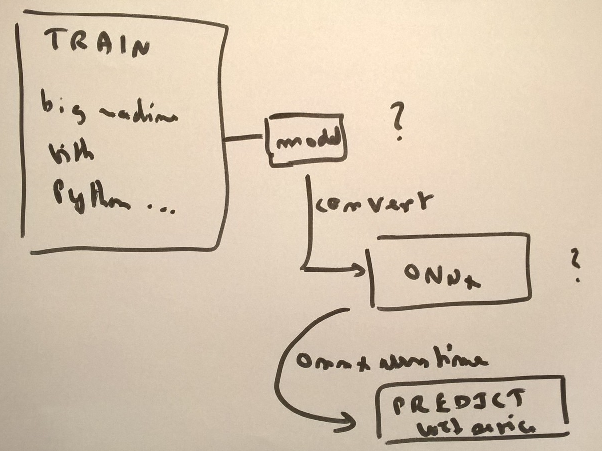

In [18]:
NbImage("process.png", width=500)

In [19]:
rf

RandomForestRegressor(n_estimators=10)

### Conversion to ONNX

[sklearn-onnx](https://github.com/onnx/sklearn-onnx)

In [20]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
model_onnx = convert_sklearn(rf, "rf_diabetes", 
                             [('input', FloatTensorType([1, 10]))])

In [21]:
print(str(model_onnx)[:450] + "\n...")

ir_version: 6
producer_name: "skl2onnx"
producer_version: "1.7.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "input"
    output: "variable"
    name: "TreeEnsembleRegressor"
    op_type: "TreeEnsembleRegressor"
    attribute {
      name: "n_targets"
      i: 1
      type: INT
    }
    attribute {
      name: "nodes_falsenodeids"
      ints: 324
      ints: 243
      ints: 146
      ints: 105
      ints: 62
   
...


### Save the model

In [22]:
with open('rf_sklearn.onnx', "wb") as f:
    f.write(model_onnx.SerializeToString())

### Compute predictions

In [23]:
import onnxruntime

sess = onnxruntime.InferenceSession("rf_sklearn.onnx")

for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='input', type='tensor(float)', shape=[1, 10])
Output: NodeArg(name='variable', type='tensor(float)', shape=[1, 1])


In [24]:
import numpy

def predict_onnxrt(x):
    return sess.run(["variable"], {'input': x})

print("Prediction:", predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32)))

Prediction: [array([[177.40001]], dtype=float32)]


In [25]:
measures_rf += [timeexec("onnx", "predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32))", 
                         context=globals())]

Average: 18.94 µs deviation 11.57 µs (with 50 runs) in [12.18 µs, 43.00 µs]


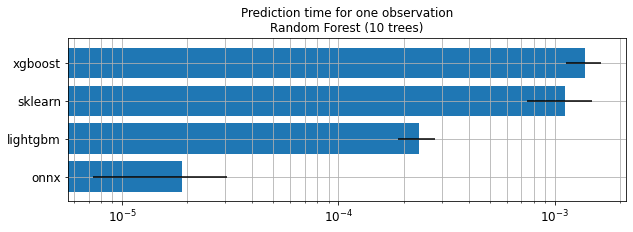

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

## Deep learning

* transfer learning with keras
* orther convert pytorch, caffee...

Code is available at [MS Experience 2018](http://www.xavierdupre.fr/app/jupytalk/helpsphinx/notebooks/onnx_deploy.html#deep-learning).

### Perf

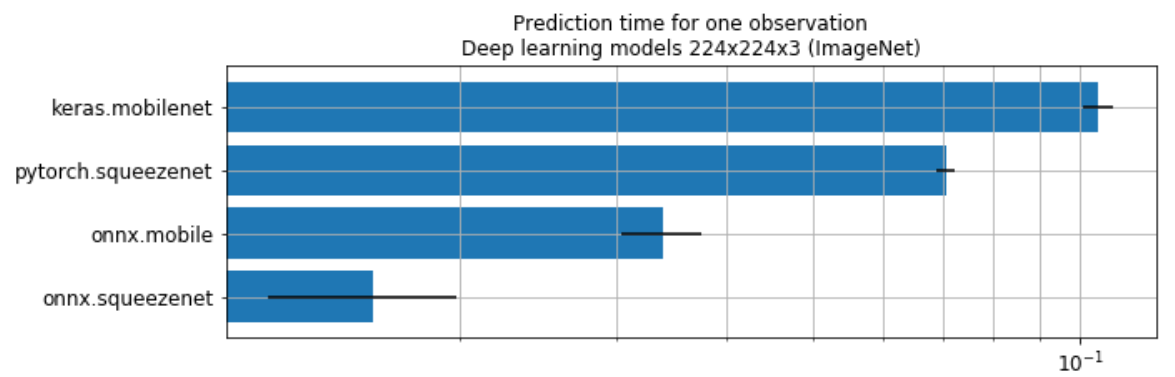

In [27]:
NbImage("dlpref.png", width=600)

### Model zoo

[Converted Models](https://github.com/onnx/models)

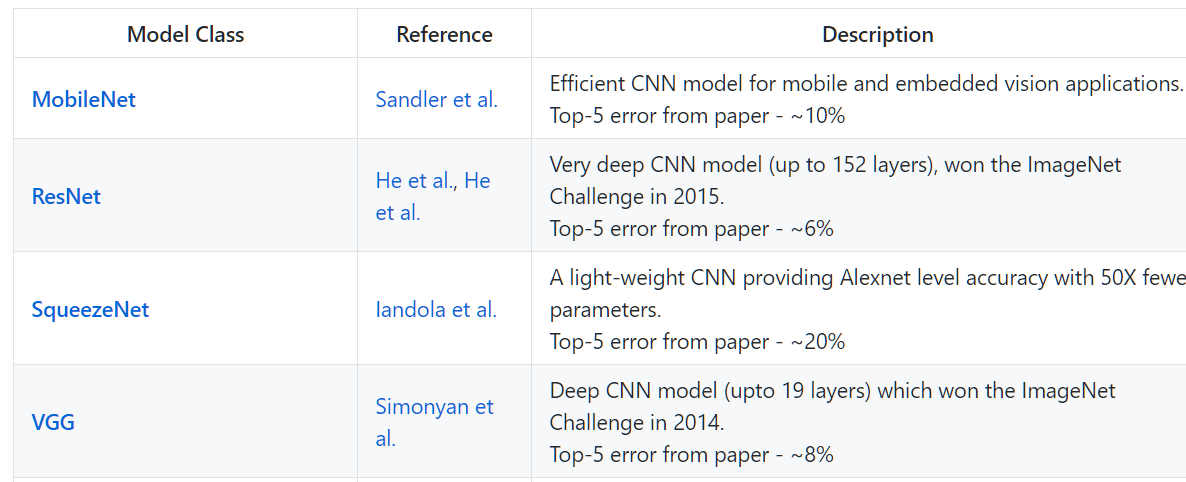

In [28]:
NbImage("zoo.png", width=800)

### Tiny yolo

Source: [TinyYOLOv2 on onnx](https://mc.ai/tinyyolov2-on-onnx/)

In [29]:
from pyensae.datasource import download_data
download_data("tiny_yolov2.tar.gz",
              url="https://onnxzoo.blob.core.windows.net/models/opset_8/tiny_yolov2/")

['.\\tiny_yolov2/./Model.onnx',
 '.\\tiny_yolov2/./test_data_set_2/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_2/output_0.pb',
 '.\\tiny_yolov2/./test_data_set_1/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_1/output_0.pb',
 '.\\tiny_yolov2/./test_data_set_0/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_0/output_0.pb']

In [30]:
sess = onnxruntime.InferenceSession("tiny_yolov2/Model.onnx")
for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='image', type='tensor(float)', shape=['None', 3, 416, 416])
Output: NodeArg(name='grid', type='tensor(float)', shape=['None', 125, 13, 13])


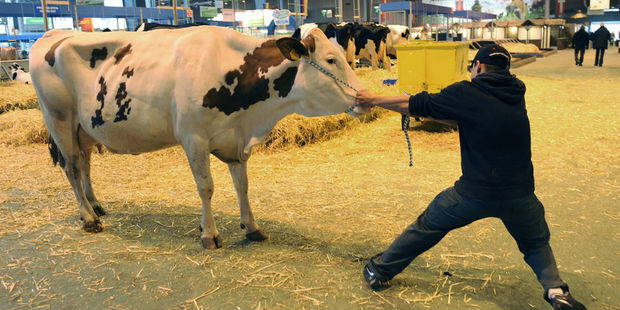

In [31]:
from PIL import Image,ImageDraw
img = Image.open('Au-Salon-de-l-agriculture-la-campagne-recrute.jpg')
img

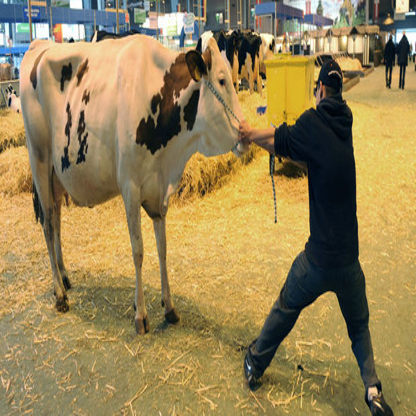

In [32]:
img2 = img.resize((416, 416))
img2

In [33]:
X = numpy.asarray(img2)
X = X.transpose(2,0,1)
X = X.reshape(1,3,416,416)

out = sess.run(None, {'image': X.astype(numpy.float32)})
out = out[0][0]

In [34]:
def display_yolo(img, seuil):
    import numpy as np
    numClasses = 20
    anchors = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]

    def sigmoid(x, derivative=False):
        return x*(1-x) if derivative else 1/(1+np.exp(-x))

    def softmax(x):
        scoreMatExp = np.exp(np.asarray(x))
        return scoreMatExp / scoreMatExp.sum(0)

    clut = [(0,0,0),(255,0,0),(255,0,255),(0,0,255),(0,255,0),(0,255,128),
            (128,255,0),(128,128,0),(0,128,255),(128,0,128),
            (255,0,128),(128,0,255),(255,128,128),(128,255,128),(255,255,0),
            (255,128,128),(128,128,255),(255,128,128),(128,255,128),(128,255,128)]
    label = ["aeroplane","bicycle","bird","boat","bottle",
             "bus","car","cat","chair","cow","diningtable",
             "dog","horse","motorbike","person","pottedplant",
             "sheep","sofa","train","tvmonitor"]

    draw = ImageDraw.Draw(img)
    for cy in range(0,13):
        for cx in range(0,13):
            for b in range(0,5):
                channel = b*(numClasses+5)
                tx = out[channel  ][cy][cx]
                ty = out[channel+1][cy][cx]
                tw = out[channel+2][cy][cx]
                th = out[channel+3][cy][cx]
                tc = out[channel+4][cy][cx]

                x = (float(cx) + sigmoid(tx))*32
                y = (float(cy) + sigmoid(ty))*32

                w = np.exp(tw) * 32 * anchors[2*b  ]
                h = np.exp(th) * 32 * anchors[2*b+1] 

                confidence = sigmoid(tc)

                classes = np.zeros(numClasses)
                for c in range(0,numClasses):
                    classes[c] = out[channel + 5 +c][cy][cx]
                    classes = softmax(classes)
                detectedClass = classes.argmax()

                if seuil < classes[detectedClass]*confidence:
                    color =clut[detectedClass]
                    x = x - w/2
                    y = y - h/2
                    draw.line((x  ,y  ,x+w,y ),fill=color, width=3)
                    draw.line((x  ,y  ,x  ,y+h),fill=color, width=3)
                    draw.line((x+w,y  ,x+w,y+h),fill=color, width=3)
                    draw.line((x  ,y+h,x+w,y+h),fill=color, width=3)
        
    return img

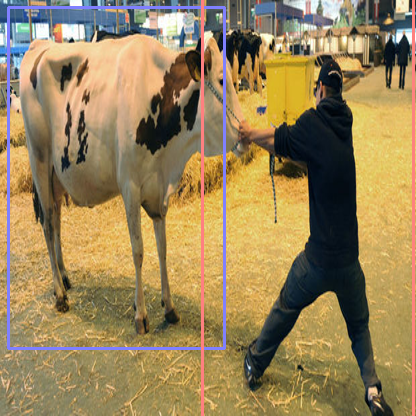

In [35]:
img2 = img.resize((416, 416))
display_yolo(img2, 0.038)

## Conclusion

* ONNX is a working progress, active development
* ONNX is open source
* ONNX does not depend on the machine learning framework
* ONNX provides dedicated runtimes
* ONNX is fast and available in Python...

**Metadata to trace deployed models**

In [36]:
meta = sess.get_modelmeta()
meta.description

"The Tiny YOLO network from the paper 'YOLO9000: Better, Faster, Stronger' (2016), arXiv:1612.08242"

In [37]:
meta.producer_name, meta.version

('OnnxMLTools', 0)